# Welcome the challenge notebook 
--- 


In this challenge, you will work with a dataset provided by an HR manager who wants to predict which employees are at risk of leaving the company. The dataset contains four key performance indicators (KPIs) related to each employee. Your task is to use PySpark to build a machine learning model that can predict employee attrition and to identify which KPI is most strongly associated with attrition in this company.

- Please note that the dataset is already clean and ready to be modeled. 
- The dataset only contains numerical features.

Installing pyspark

In [1]:
!pip install pyspark

Importing the needed modules and creating the spark session

In [2]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [3]:
!pip install pyspark

In [12]:
# importing spark session
from pyspark.sql import SparkSession

# data visualization modules 
import matplotlib.pyplot as plt
import plotly.express as px 

# pandas module 
import pandas as pd

# pyspark data preprocessing modules
from pyspark.ml.feature import  VectorAssembler, StandardScaler,StringIndexer

# pyspark data modeling and model evaluation modules
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# creating the spark session
spark = SparkSession.builder.appName("Challenge").getOrCreate()
spark

Loading the `Challenge_dataset.csv` file

In [5]:
data = spark.read.format('csv').option('header',True).option('inferSchema',True).load('Challenge_dataset.csv')
data.show(5)

+----------+------------------+-------------------+-------------------+-------------------+---------------+
|EmployeeID|              KPI1|               KPI2|               KPI3|               KPI4|CurrentEmployee|
+----------+------------------+-------------------+-------------------+-------------------+---------------+
|         0|1.4347155493478079| 0.8445778971189396| 1.2907117554310856|-1.4201273531837943|              1|
|         1|0.8916245735832885| 0.8308158727699302| 1.0779750584283363|-1.0598957663940176|              1|
|         2|-0.891158353098296|-0.9469681237741348|-1.1825287909456643| 1.1269205082112577|              0|
|         3|1.2797294893867808| 1.6690888870054317| 1.9769417044649022| -1.797525912345404|              1|
|         4|0.2576789316661615|0.34201906896710577|0.40342208520171396|-0.3653830886145554|              1|
+----------+------------------+-------------------+-------------------+-------------------+---------------+
only showing top 5 rows



Create the numerical feature vector using `Vector Assembler`.

Hint: The numerical input features are the KPIs.

In [9]:
# Define VectorAssembler
feature_cols = ['KPI1', 'KPI2', 'KPI3', 'KPI4']
assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')

# Transform the DataFrame
df_vector = assembler.transform(data)

# Show results
df_vector.select('EmployeeID', 'features').show(truncate=False)

+----------+---------------------------------------------------------------------------------+
|EmployeeID|features                                                                         |
+----------+---------------------------------------------------------------------------------+
|0         |[1.4347155493478079,0.8445778971189396,1.2907117554310856,-1.4201273531837943]   |
|1         |[0.8916245735832885,0.8308158727699302,1.0779750584283363,-1.0598957663940176]   |
|2         |[-0.891158353098296,-0.9469681237741348,-1.1825287909456643,1.1269205082112577]  |
|3         |[1.2797294893867808,1.6690888870054317,1.9769417044649022,-1.797525912345404]    |
|4         |[0.2576789316661615,0.34201906896710577,0.40342208520171396,-0.3653830886145554] |
|5         |[-1.1053563591145563,-1.2897283732181386,-1.5705804494874567,1.464531035393369]  |
|6         |[-1.1428601324433787,-0.8267980776185402,-1.1670251067377129,1.2205208819355595] |
|7         |[0.3271989171852082,-0.847540081925909

Apply `Standard Scaler` to the numerical feature vector

In [10]:
# Apply Standard Scaler 
scaler = StandardScaler(inputCol='features', outputCol='scaled_features', withMean=True, withStd=True)
scaler_model = scaler.fit(df_vector)
df_scaled = scaler_model.transform(df_vector)

# Show results
df_scaled.select('EmployeeID', 'features', 'scaled_features').show(truncate=False)

+----------+---------------------------------------------------------------------------------+----------------------------------------------------------------------------------+
|EmployeeID|features                                                                         |scaled_features                                                                   |
+----------+---------------------------------------------------------------------------------+----------------------------------------------------------------------------------+
|0         |[1.4347155493478079,0.8445778971189396,1.2907117554310856,-1.4201273531837943]   |[1.0821889060059904,0.5990118540251474,0.7811996672489705,-0.917674288601056]     |
|1         |[0.8916245735832885,0.8308158727699302,1.0779750584283363,-1.0598957663940176]   |[0.6731950794597595,0.5893024579360331,0.6529247558109035,-0.685560869322681]     |
|2         |[-0.891158353098296,-0.9469681237741348,-1.1825287909456643,1.1269205082112577]  |[-0.669392523028

Split the data into train and test sets

In [11]:
# Split the data into train (80%) and test (20%) sets
train_data, test_data = df_scaled.randomSplit([0.8, 0.2], seed=42)

# Print the size of train and test sets
print(f"Training Data Count: {train_data.count()}")
print(f"Test Data Count: {test_data.count()}")

# Show examples in the training set
train_data.select("EmployeeID", "scaled_features").show(5, truncate=False)

Training Data Count: 3258
Test Data Count: 742
+----------+--------------------------------------------------------------------------------+
|EmployeeID|scaled_features                                                                 |
+----------+--------------------------------------------------------------------------------+
|0         |[1.0821889060059904,0.5990118540251474,0.7811996672489705,-0.917674288601056]   |
|1         |[0.6731950794597595,0.5893024579360331,0.6529247558109035,-0.685560869322681]   |
|3         |[0.9654711836473173,1.1807216067194841,1.1949791758089086,-1.1608491605726645]  |
|4         |[0.19577994004412247,0.2444460868923104,0.2461861718240913,-0.23805510280130313]|
|5         |[-0.830701891124578,-0.9067858708331639,-0.9440880210317879,0.9410409006736643] |
+----------+--------------------------------------------------------------------------------+
only showing top 5 rows



Train your Decision Tree model. Use `maxDepth = 3`

In [14]:
# Identify the column
target_column = "CurrentEmployee"

# Train Decision Tree Classifier
dt = DecisionTreeClassifier(labelCol=target_column, featuresCol="scaled_features", maxDepth=3)
dt_model = dt.fit(train_data)

# Make predictions of the test data
predictions = dt_model.transform(test_data)

# Evaluate Model Performance
evaluator = MulticlassClassificationEvaluator(labelCol=target_column, predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

# Print results
print(f"Decision Tree Model Accuracy:{accuracy:.4f}")
predictions.select("EmployeeID", "CurrentEmployee", "prediction").show(10, truncate=False)

Decision Tree Model Accuracy:0.8976
+----------+---------------+----------+
|EmployeeID|CurrentEmployee|prediction|
+----------+---------------+----------+
|2         |0              |0.0       |
|6         |0              |0.0       |
|8         |0              |0.0       |
|13        |1              |1.0       |
|19        |1              |0.0       |
|23        |1              |1.0       |
|29        |0              |0.0       |
|35        |1              |0.0       |
|45        |1              |1.0       |
|46        |1              |0.0       |
+----------+---------------+----------+
only showing top 10 rows



Perform the prediction on the test set and calculate the accuracy using `BinaryClassificationEvaluator`

In [20]:
# Step 1: Create the feature vector
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_vector = assembler.transform(data)

# Step 2: Apply StandardScaler
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)
scaler_model = scaler.fit(df_vector)
df_scaled = scaler_model.transform(df_vector)

# Alternative: If "CurrentEmployee" is categorical, use StringIndexer
indexer = StringIndexer(inputCol="CurrentEmployee", outputCol="label")
df_scaled = indexer.fit(df_scaled).transform(df_scaled)

# Step 4: Split the data into training (80%) and testing (20%) sets
train_data, test_data = df_scaled.randomSplit([0.8, 0.2], seed=42)

# Step 5: Train Decision Tree Classifier
dt = DecisionTreeClassifier(labelCol="label", featuresCol="scaled_features", maxDepth=3)
dt_model = dt.fit(train_data)

# Step 6: Make predictions on the test set
predictions = dt_model.transform(test_data)

# Step 7: Evaluate Model Performance using BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
roc_auc = evaluator.evaluate(predictions)

# Step 8: Show Results
print(f"Decision Tree Model AUC-ROC: {roc_auc:.4f}")
predictions.select("EmployeeID", "label", "prediction", "rawPrediction", "probability").show(10, truncate=False)

Java HotSpot(TM) 64-Bit Server VM warning: CodeCache is full. Compiler has been disabled.
Java HotSpot(TM) 64-Bit Server VM warning: Try increasing the code cache size using -XX:ReservedCodeCacheSize=


CodeCache: size=131072Kb used=42972Kb max_used=42978Kb free=88099Kb
 bounds [0x00000001061f8000, 0x0000000108c28000, 0x000000010e1f8000]
 total_blobs=15046 nmethods=13998 adapters=958
 compilation: disabled (not enough contiguous free space left)
Decision Tree Model AUC-ROC: 0.8335
+----------+-----+----------+-------------+----------------------------------------+
|EmployeeID|label|prediction|rawPrediction|probability                             |
+----------+-----+----------+-------------+----------------------------------------+
|2         |0.0  |0.0       |[1462.0,96.0]|[0.938382541720154,0.06161745827984596] |
|6         |0.0  |0.0       |[1462.0,96.0]|[0.938382541720154,0.06161745827984596] |
|8         |0.0  |0.0       |[1462.0,96.0]|[0.938382541720154,0.06161745827984596] |
|13        |1.0  |1.0       |[70.0,1355.0]|[0.04912280701754386,0.9508771929824561]|
|19        |1.0  |0.0       |[88.0,83.0]  |[0.5146198830409356,0.4853801169590643] |
|23        |1.0  |1.0       |[1.0,15.

Apply the hyper paramter tuning to find the proper `maxDepth` for your decision tree from the `candidates` list.

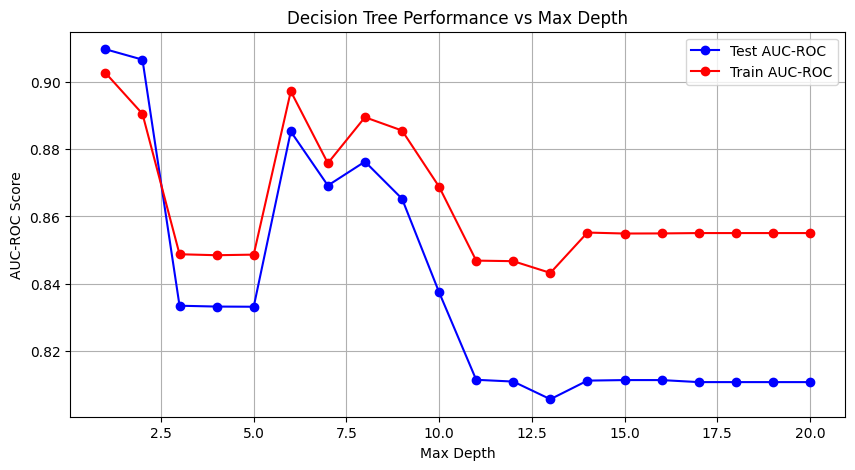

In [24]:
def evaluate_dt(mode_params):
      test_accuracies = []
      train_accuracies = []

      for maxD in mode_params:
        # train the model based on the maxD
        decision_tree = DecisionTreeClassifier(featuresCol = 'scaled_features', labelCol = 'CurrentEmployee', maxDepth = maxD)
        dtModel = decision_tree.fit(train_data)

        # calculating test error 
        predictions_test = dtModel.transform(test_data)
        evaluator = BinaryClassificationEvaluator(labelCol='CurrentEmployee')
        auc_test = evaluator.evaluate(predictions_test, {evaluator.metricName: "areaUnderROC"})
        # recording the accuracy 
        test_accuracies.append(auc_test)

        # calculating training error
        predictions_training = dtModel.transform(train_data)
        evaluator = BinaryClassificationEvaluator(labelCol='CurrentEmployee')
        auc_training = evaluator.evaluate(predictions_training, {evaluator.metricName: "areaUnderROC"})
        train_accuracies.append(auc_training)

      return(test_accuracies, train_accuracies)  



candidates = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

# Run evaluation
test_accuracies, train_accuracies = evaluate_dt(candidates)

# Plot results
plt.figure(figsize=(10,5))
plt.plot(candidates, test_accuracies, marker="o", label="Test AUC-ROC", color="blue")
plt.plot(candidates, train_accuracies, marker="o", label="Train AUC-ROC", color="red")
plt.xlabel("Max Depth")
plt.ylabel("AUC-ROC Score")
plt.title("Decision Tree Performance vs Max Depth")
plt.legend()
plt.grid()
plt.show()

Use a line chart to visualize the training and testing accuracy. <br>

Hint: To visualize your data, convert the PySpark dataframe to pandas dataframe.

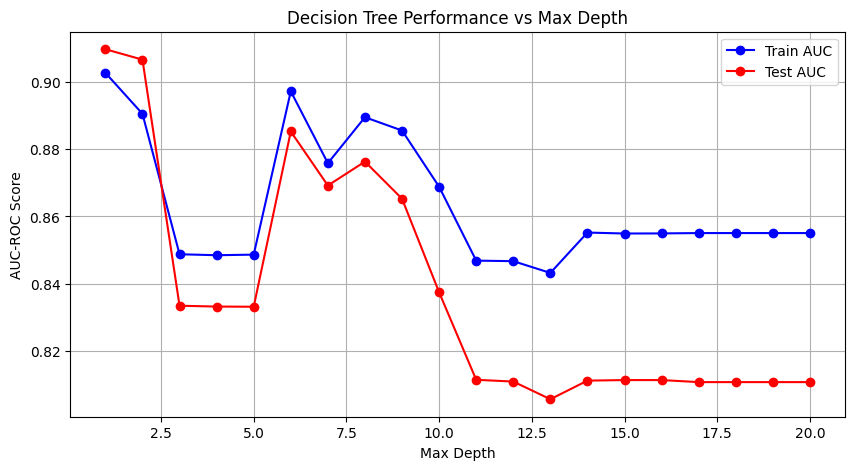

In [25]:
# Convert results to Pandas DataFrame
results_df = pd.DataFrame({"maxDepth": candidates, "Train AUC": train_accuracies, "Test AUC": test_accuracies})

# Plot the results
plt.figure(figsize=(10,5))
plt.plot(results_df["maxDepth"], results_df["Train AUC"], marker="o", label="Train AUC", color="blue")
plt.plot(results_df["maxDepth"], results_df["Test AUC"], marker="o", label="Test AUC", color="red")
plt.xlabel("Max Depth")
plt.ylabel("AUC-ROC Score")
plt.title("Decision Tree Performance vs Max Depth")
plt.legend()
plt.grid()
plt.show()

Train the decision tree using the proper `maxDepth` parameter.  

In [26]:
# Find the best Max Depth (where AUC is the highest)
best_maxDepth = candidates[test_accuracies.index(max(test_accuracies))]
print(f"Optimal maxDepth: {best_maxDepth}")

# Train the final Decision Tree model with optimal maxDepth
final_dt = DecisionTreeClassifier(featuresCol="scaled_features", labelCol="label", maxDepth=best_maxDepth)
final_model = final_dt.fit(train_data)

# Make prediction on the test set
final_predictions = final_model.transform(test_data)

# Evaluate final model
final_evaluator = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")
final_auc = final_evaluator.evaluate(final_predictions)

print(f"Final Model AUC-ROC on Test Set: {final_auc:.4f}")

Optimal maxDepth: 1
Final Model AUC-ROC on Test Set: 0.9097


Use the `Feature Importance` to find the most important factor for the employee attrition using a barchart.

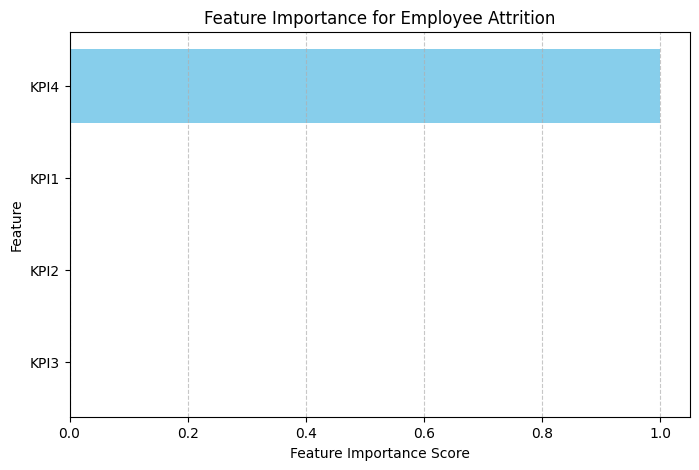

25/02/21 09:05:50 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 2003544 ms exceeds timeout 120000 ms
25/02/21 09:05:50 WARN SparkContext: Killing executors is not supported by current scheduler.
25/02/21 09:05:58 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$

In [28]:
# Extract feature importance values
feature_importance = final_model.featureImportances.toArray().tolist()

# Define the original feature names
feature_names = ["KPI1", "KPI2", "KPI3", "KPI4"]

# Convert to Pandas DataFrame
importance_df = pd.DataFrame({"Feature": feature_names, "Importance": feature_importance})

# Sort by importance (descending order)
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Plot feature importances as bar chart
plt.figure(figsize=(8,5))
plt.barh(importance_df["Feature"], importance_df["Importance"], color="skyblue")
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature")
plt.title("Feature Importance for Employee Attrition")
plt.gca().invert_yaxis()
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()